# PAMM Clustering - Whole Dataset

Sample Notebook to use PAMM clustering algorithm (orignal [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00993)) with the GMPLabTools implementation.

The keyword **WHOLE** dataset refers to the tratments of the dataset towards the kernel density estimation (KDE), which are "summed" togheter.

In [1]:
import time
import warnings
import random
import seaborn as sns
import numpy as np

from scipy.cluster.hierarchy import dendrogram
from gmplabtools.analysis import DataSampler
from gmplabtools.pamm import PammGMM
from gmplabtools.pamm import Pamm
from gmplabtools.analysis import calculate_adjacency, adjancency_dendrogram
from gmplabtools.analysis import ClusterRates

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import time
import warnings
import random
import seaborn as sns
import numpy as np
from scipy.cluster.hierarchy import dendrogram
!conda activate gmplabtools


CommandNotFoundError: Your shell has not been properly configured to use 'conda activate'.
To initialize your shell, run

    $ conda init <SHELL_NAME>

Currently supported shells are:
  - bash
  - fish
  - tcsh
  - xonsh
  - zsh
  - powershell

See 'conda init --help' for more information and options.

IMPORTANT: You may need to close and restart your shell after running 'conda init'.




## Utilities Functions

In [3]:
def make_colors(clust,mode='tab10'):
    if np.min(clust) == -1:
        N = np.unique(clust).shape[0] - 1
        colors = sns.color_palette(mode, N) + [(0,0,0)]
    else:
        N = np.unique(clust).max()
        colors = sns.color_palette(mode, N) 
    return colors


def get_axes(L, max_col=3, fig_frame=(5,4), res=100):
    cols = L if L <= max_col else max_col
    rows = int(L / max_col) + int(L % max_col != 0)
    fig, ax = plt.subplots(rows, cols, figsize=(cols * fig_frame[0], rows * fig_frame[1]), dpi=res)
    if L !=1 :
        ax =  ax.flatten()
    return fig, ax


def shuffle(X, Y=None, n=None):
    l = np.arange(X.shape[0])
    random.shuffle(l)
    if Y is None:
        return X[l[:n],:]
    elif Y is None and n is None:
        return X[l,:]
    elif n is None:
        return X[l,:], Y[l]
    else: 
        return X[l[:n],:], Y[l[:n]]



## Dataset definition and loading

In [4]:
def arrowed_spines(
        ax,
        x_width_fraction=0.05,
        x_height_fraction=0.05,
        lw=None,
        ohg=0.3,
        locations=('bottom right', 'left up'),
        **arrow_kwargs
):
    """
    Add arrows to the requested spines
    Code originally sourced here: https://3diagramsperpage.wordpress.com/2014/05/25/arrowheads-for-axis-in-matplotlib/
    And interpreted here by @Julien Spronck: https://stackoverflow.com/a/33738359/1474448
    Then corrected and adapted by me for more general applications.
    :param ax: The axis being modified
    :param x_{height,width}_fraction: The fraction of the **x** axis range used for the arrow height and width
    :param lw: Linewidth. If not supplied, default behaviour is to use the value on the current left spine.
    :param ohg: Overhang fraction for the arrow.
    :param locations: Iterable of strings, each of which has the format "<spine> <direction>". These must be orthogonal
    (e.g. "left left" will result in an error). Can specify as many valid strings as required.
    :param arrow_kwargs: Passed to ax.arrow()
    :return: Dictionary of FancyArrow objects, keyed by the location strings.
    """
    # set/override some default plotting parameters if required
    arrow_kwargs.setdefault('overhang', ohg)
    arrow_kwargs.setdefault('clip_on', False)
    arrow_kwargs.update({'length_includes_head': True})

    # axis line width
    if lw is None:
        # FIXME: does this still work if the left spine has been deleted?
        lw = ax.spines['left'].get_linewidth()

    annots = {}

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()

    # get width and height of axes object to compute
    # matching arrowhead length and width
    fig = ax.get_figure()
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = x_width_fraction * (ymax-ymin)
    hl = x_height_fraction * (xmax-xmin)

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    for loc_str in locations:
        side, direction = loc_str.split(' ')
        assert side in {'top', 'bottom', 'left', 'right'}, "Unsupported side"
        assert direction in {'up', 'down', 'left', 'right'}, "Unsupported direction"

        if side in {'bottom', 'top'}:
            if direction in {'up', 'down'}:
                raise ValueError("Only left/right arrows supported on the bottom and top")

            dy = 0
            head_width = hw
            head_length = hl

            y = ymin if side == 'bottom' else ymax

            if direction == 'right':
                x = xmin
                dx = xmax - xmin
            else:
                x = xmax
                dx = xmin - xmax

        else:
            if direction in {'left', 'right'}:
                raise ValueError("Only up/downarrows supported on the left and right")
            dx = 0
            head_width = yhw
            head_length = yhl

            x = xmin if side == 'left' else xmax

            if direction == 'up':
                y = ymin
                dy = ymax - ymin
            else:
                y = ymax
                dy = ymin - ymax


        annots[loc_str] = ax.arrow(x, y, dx, dy, fc='k', ec='k', lw = lw,
                 head_width=head_width, head_length=head_length, **arrow_kwargs)

    return annots

The data that one wants to process needs to be load and initialized as follows

`SYSX1 = np.loadtxt(my_dir/my_fileX1)`

and then put in a well named dictionary

`SYST = {
    'name_X1' : SYSX1,
    'name_X2' : SYSX2,
        ...   : ...  ,
}`

As stated before in this workflow one need to define a _wholesystemData_ and store it accordingly

`ALL = np.loadtxt(my_dir/my_wholedata)`

In [26]:
PCA_DIR='SYS-A/pca_files'

In [27]:
SYS0 = np.loadtxt(PCA_DIR+'/PCA_200mol_rcut40_trj0-3000-10.pca')
SYS1 = np.loadtxt(PCA_DIR+'/PCA_310mol_rcut40_trj0-2000-10.pca')
SYS2 = np.loadtxt(PCA_DIR+'/PCA_400mol_rcut40_trj0-2000-10.pca')
ALL = np.loadtxt(PCA_DIR+'/wholesystem.pca')

In [28]:
SYST = {
    '200mol' : SYS0,
    '310mol' : SYS1,
    '400mol' : SYS2,
}

In [29]:
DIM = ALL.shape[1]
print(f"Data dimensions considered: {DIM}")

Data dimensions considered: 5


In [30]:
ALL.shape

(202000, 5)

## General variables

In [31]:
CHUNK = 5000
LABEL_SIZE = 18
L = len(SYST)
SAVE_PLOT = True

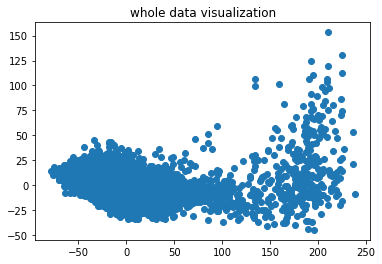

In [32]:
shffull = shuffle(ALL)

fig, ax = plt.subplots()
ax.scatter(shffull[:CHUNK,0], shffull[:CHUNK,1])
ax.set_title('whole data visualization')
gx = ax.get_xlim()
gy = ax.get_ylim()   

## Algorithm inputs

The paramters for the calculation needs to be stored as follows.

The meaning of these parameters can be found in the orignal [paper](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.7b00993).

The `nm_frame` refers to how many components a frame of the trajectory is composed (es. fiber having 40 monomers `nm_frame : 40`).

In [33]:
default_inputs = dict(
    # cluster
    distance = "minkowski",
    size = 3000,
    p = 2,
    generate_grid = True,
    savegrid = "grid_data",
    # cluster inputs
    d = DIM,
    fspread = 0.2,
    ngrid = 200,
    qs = 1,
    o = "pamm",
    trajectory = PCA_DIR+"/wholesystem.pca",
    merger = 0.005,
    bootstrap = 73
)

In [34]:
datasets_cluster = [
    (ALL, {}),
]

datasets_predict = [
    (SYS0, {'sys' : '200mol', 'nm_frame' : 200}),
    (SYS1, {'sys' : '310mol', 'nm_frame' : 310}),
    (SYS2, {'sys' : '400mol', 'nm_frame' : 400}),
]

## Original dataset plot

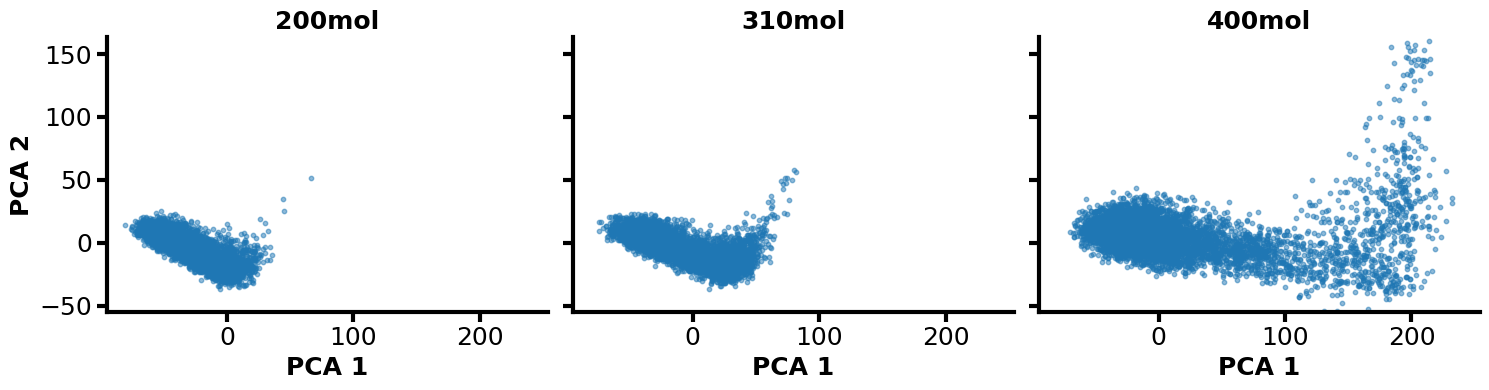

In [35]:
colors=sns.color_palette('tab10', L)
fig, ax = get_axes(L, max_col=L)
for i,s in enumerate(SYST):
    ax[i].scatter(SYST[s][:CHUNK,0], SYST[s][:CHUNK,1], s=10, linewidth=1, marker="o", alpha=0.5)
    ax[i].set_xlim(gx)
    ax[i].set_ylim(gy)
    ax[i].set_title(f"{s}", weight='bold',size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_linewidth(3)
    
    if i == 0:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)          
    else:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].tick_params(labelleft=None)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)

fig.tight_layout()

if SAVE_PLOT:
    plt.savefig("data_set_soap_pca.png")

## PAMM - Clustering part

In [36]:
for i_dataset, (dataset, algo_params) in enumerate(datasets_cluster):
    # update parameters with dataset-specific values
    params = default_inputs.copy()
    params.update(algo_params)

    # Clustering
    p = Pamm(params)
    print('\n#-----------------------------------------------')
    print(p.command_parser)
    
    print('\nRUNNING Clustering')
    t0 = time.time()
    p.run()
    t1 = time.time()
    print('TIME= '+str(np.round(t1-t0, 2))+' s \n')


#-----------------------------------------------
/home/admsupsi/anaconda3/lib/python3.9/site-packages/gmplabtools-0.0.0-py3.9.egg/gmplabtools/pamm/bin/pamm -d 5 -bootstrap 73 -fspread 0.2 -qs 1 -o pamm -ngrid 200 -merger 0.005 -v < SYS-A/pca_files/wholesystem.pca

RUNNING Clustering
Executing command: /home/admsupsi/anaconda3/lib/python3.9/site-packages/gmplabtools-0.0.0-py3.9.egg/gmplabtools/pamm/bin/pamm -d 5 -bootstrap 73 -fspread 0.2 -qs 1 -o pamm -ngrid 200 -merger 0.005 -v < SYS-A/pca_files/wholesystem.pca
TIME= 4.31 s 



## PAMM - Prediction on data part

In [37]:
gmm = PammGMM.read_clusters('pamm.pamm', 
                                grid_file='pamm.grid', 
                                bootstrap_file='pamm.bs')
NUM_CLUST=np.unique(gmm.pk).shape[0]
print(f"There are {NUM_CLUST} clusters")

There are 5 clusters


In [38]:
cluster_output = {}
grid_cluster = {}
prob_output = {}
bootstr_output = {}
systnames = []
for i_dataset,dataset in enumerate(datasets_predict):
    run_syst = str(datasets_predict[i_dataset][1]['sys'])
    # Predict
    print('\nRUNNING Predict '+run_syst)
    t0 = time.time()
    
    x = datasets_predict[i_dataset][0]
    x_ = gmm.predict_proba(x)
    labels = np.argmax(x_, axis=1) #.reshape((-1, 1))

    t1 = time.time()
    print('TIME= '+str(np.round(t1-t0, 2))+' s \n')

    # Storing data
    cluster_output[run_syst] = labels
    grid_cluster[run_syst] = gmm.cluster
    prob_output[run_syst] = gmm.p
    bootstr_output[run_syst] = gmm.bs
    systnames.append(run_syst)

    # output for initial clustering
    np.savetxt(run_syst + "_clusters.dat", labels.reshape((-1, 1)))
    
    rates = ClusterRates(datasets_predict[i_dataset][1]['nm_frame'], 'label').calculate_matrix(labels.reshape((-1, 1)))
    np.savetxt(run_syst + "_rates.dat", rates)


RUNNING Predict 200mol
TIME= 2.12 s 


RUNNING Predict 310mol
TIME= 2.22 s 


RUNNING Predict 400mol
TIME= 2.74 s 



## Output post-processing

In [39]:
def PLTmatrixrates(ax,data,s=18):
    labels = ['0','1','2','3','4']
    sns.heatmap(data, annot=True, fmt=".2f", cbar=False, ax=ax, annot_kws={"fontsize":s})
    ax.xaxis.tick_top()
#     ax.set_xticklabels(labels, size='18', weight='bold')
#     ax.set_yticklabels(labels, size='18', weight='bold')
    return ax

200mol
310mol
400mol


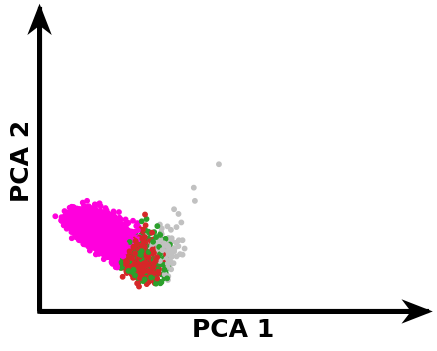

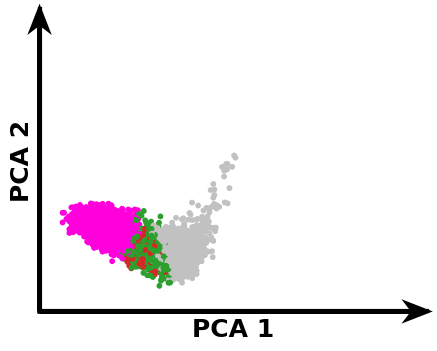

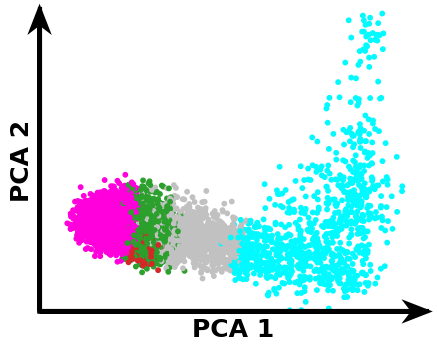

In [40]:
# pink cyan gray
colors = ["#ff00ddff", "#00faffff", "#c1c1c1ff","tab:green","tab:red"]

for i,sys in enumerate(systnames):
    fig, ax = get_axes(1, max_col=L)

    labels = cluster_output[sys]
    
    ax.scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
    ax.set_xlim(gx)
    ax.set_ylim(gy)
    

    for side in ['bottom','right','top','left']:
        ax.spines[side].set_linewidth(3)
    

    ax.set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
    ax.set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
    for side in ['right','top']:
        ax.spines[side].set_visible(False)

    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    left=False,      
    labelleft=False,
    labelbottom=False) 
    annots = arrowed_spines(ax, locations=('bottom right', 'left up'))    
    print(f"{sys}")

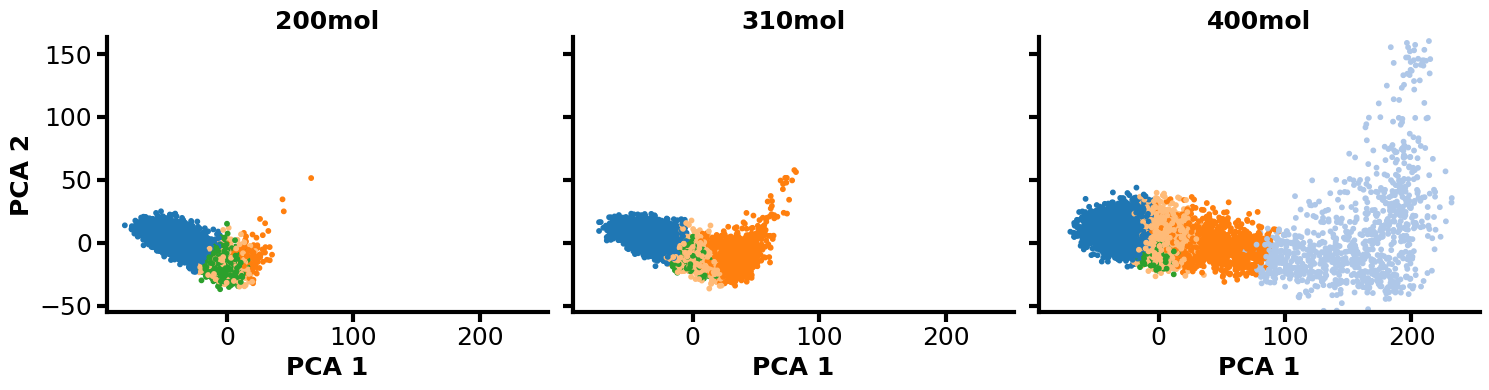

In [41]:
colors=make_colors(NUM_CLUST,mode='tab20')
fig, ax = get_axes(L, max_col=L)
for i,sys in enumerate(systnames):
    labels = cluster_output[sys]
    ax[i].scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
    ax[i].set_xlim(gx)
    ax[i].set_ylim(gy)
    ax[i].set_title(f"{sys}", weight='bold',size=LABEL_SIZE)
    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_linewidth(3)
    
    if i == 0:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)          
    else:
        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
        ax[i].tick_params(labelleft=None)
        for side in ['right','top']:
            ax[i].spines[side].set_visible(False)

fig.tight_layout()

if SAVE_PLOT:
    fig.savefig('clusters_pamm.png')

### Cluster iterconversion matrices

These matrices $N_{clusters} \times N_{clusters}$ represent all the transfomation that clusters undergo during the trajectories analyzed.
A sample row $n_i$ gives you the probability, in terms of frequency, of that cluster to becomes the $n_j$ column cluster.

In [42]:
SYS0rates = np.loadtxt("./200mol_rates.dat")
SYS1rates = np.loadtxt("./310mol_rates.dat")
SYS2rates = np.loadtxt("./400mol_rates.dat")


RATES = {
    '200mol' : SYS0rates,
    '310mol' : SYS1rates,
    '400mol' : SYS2rates
}

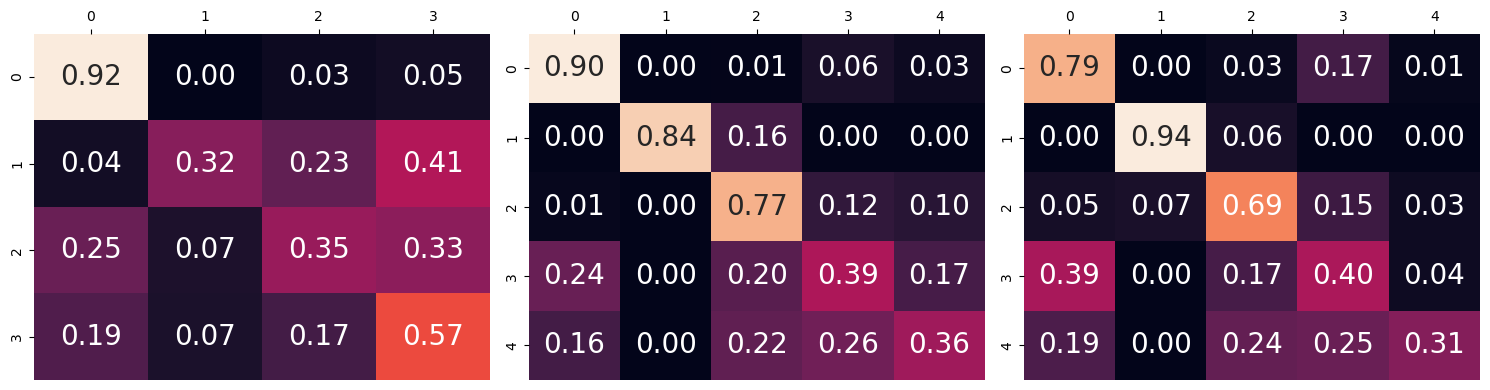

In [43]:
fig, ax = get_axes(L, max_col=4, fig_frame=(5,4), res=100)
for i,sys in enumerate(RATES):
    PLTmatrixrates(ax[i], RATES[sys], s=20)
    
fig.tight_layout()

if SAVE_PLOT:
    fig.savefig('micro_clusters_pamm_matrix.png')
    

In [44]:
sns.color_palette("tab20",5)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)]

### Clusters hierarchy

The dendrograms shoul be all identical, since the prediction on the single sets came from a merged big set.

In [45]:
prob_output.keys()

dict_keys(['200mol', '310mol', '400mol'])

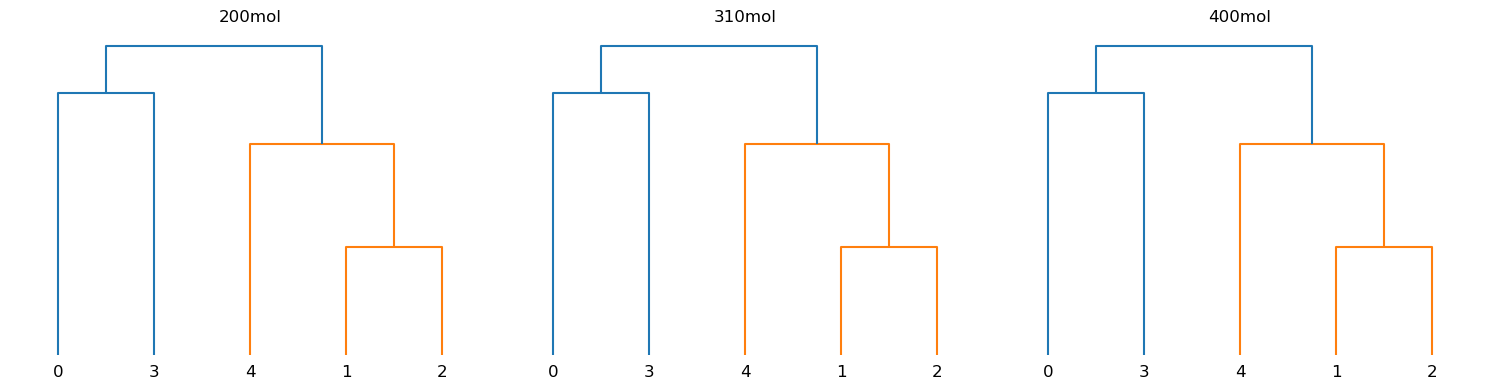

In [46]:
fig, ax = get_axes(L, max_col=L)
for i,den in enumerate(SYST):
    adjacency, mapping = calculate_adjacency(
    prob=prob_output[den],
    clusters=grid_cluster[den],
    bootstrap=bootstr_output[den]
    )

    z = adjancency_dendrogram(adjacency)
    _ = dendrogram(z, ax=ax[i], count_sort=True)['leaves']
    
    ax[i].set_title(den)
    ax[i].set_yticks([])
    ax[i].yaxis.set_ticks_position('none')
    
    for side in ['bottom','right','top','left']:
        ax[i].spines[side].set_visible(False)

fig.tight_layout()    
    
if SAVE_PLOT:
    fig.savefig('clusters_pamm_dendrogram.png')

# Clusters mearging (Macroclusters processing)

Macrocluster syntax definition:

`mapping = [
    ('SYSX1', {MacroCl1: [microClx,...], 
               MacroCl2: [microCly,...]})
]`

where the mearging comes from the dendrogram.

In [77]:
mapping = [
    ('200mol', {0: [0,3,4],
               1: [1],
               2: [2]}),
    ('310mol',   {0: [0,3,4],
               1: [1],
               2: [2]}),
    ('400mol', {0: [0,3,4],
               1: [1],
               2: [2]}),
]

In [78]:
# it does not matter if one put np.argmax(y__, axis=1).reshape((-1,1)) \w or \wout the reshape part
macro_cluster_output = {}
rates_macro_clusters = {}

for s,macro_cl in enumerate(systnames):
    # Macro Cluster
    run_syst = macro_cl
    print("MACRO CLUSTERS - "+run_syst)
    
    y = datasets_predict[s][0]
    y_ = gmm.predict_proba(y)
    y__ = np.zeros((y.shape[0], len(mapping[s][1])))
    for k, v in mapping[s][1].items():
        y__[:, k] = y_[:,v].sum(1)

    macro_cluster_output[macro_cl] = np.argmax(y__, axis=1)
    np.savetxt(run_syst+'_macro_cluster.dat', np.argmax(y__, axis=1).reshape((-1,1)) )
    
    rates = ClusterRates(datasets_predict[s][1]['nm_frame'], 'label').calculate_matrix(np.argmax(y__, axis=1).reshape((-1,1)) )
    rates_macro_clusters[macro_cl] = rates
    np.savetxt(run_syst+'_macro_rates.dat', rates)

MACRO CLUSTERS - 200mol
MACRO CLUSTERS - 310mol
MACRO CLUSTERS - 400mol


In [79]:
rates_macro_clusters

{'200mol': array([[0.98371397, 0.01628603],
        [0.70483271, 0.29516729]]),
 '310mol': array([[0.93479613, 0.        , 0.06520387],
        [0.        , 0.83552632, 0.16447368],
        [0.23551051, 0.00217718, 0.76231231]]),
 '400mol': array([[9.25726340e-01, 8.35474236e-05, 7.41901122e-02],
        [2.39391944e-04, 9.40331558e-01, 5.94290502e-02],
        [2.37178633e-01, 6.69375250e-02, 6.95883842e-01]])}

200mol
310mol
400mol


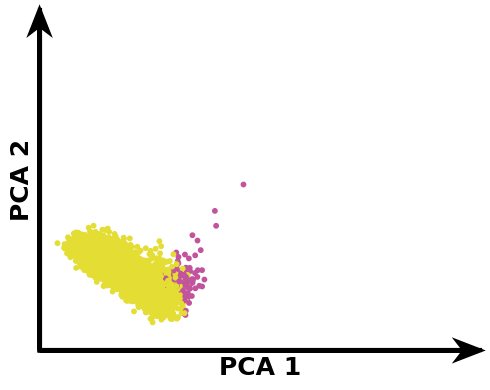

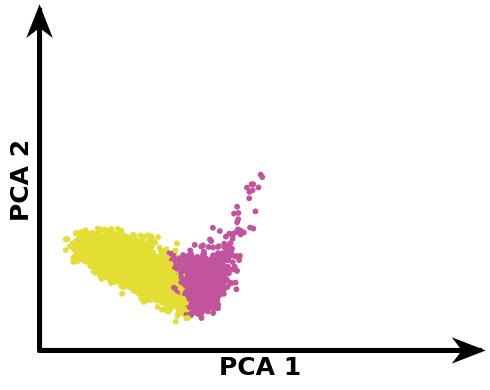

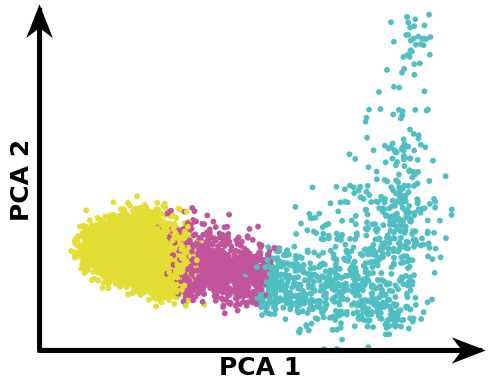

In [80]:
#Mcolors = ["#9ACD32","#FBA63B","#F05558"]
#Mcolors = ["#B34233","#E6AE35","#9ACD32"]
#Mcolors = ["#32CD32","tab:orange","#8B008B"]
#Mcolors = ["#ffe74c","#ff5964","#38618c"]
#Mcolors = ["#B4C540","#E0E2D2","#575A6c"]
#Mcolors = ["#B4C540","#E0E2D2","#575A6c"]
#Mcolors = ["#E3DD34","#50BFC3","#C1549C"]
#fig, ax = get_axes(L, max_col=L)
#for i,sys in enumerate(SYST):
#    colors=Mcolors
#    labels = macro_cluster_output[sys]
#    print(np.bincount(labels)/len(labels)*100)
#    ax[i].scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
#    ax[i].set_title(f"{sys}", weight='bold',size=LABEL_SIZE)
#    ax[i].tick_params(labelsize=LABEL_SIZE,width=3,size=7)
#    
#    ax[i].set_xlim(gx)
#    ax[i].set_ylim(gy)
#    
#    for side in ['bottom','right','top','left']:
#        ax[i].spines[side].set_linewidth(3)
#    if i == 0:
#        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
#        ax[i].set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
#        for side in ['right','top']:
#            ax[i].spines[side].set_visible(False)          
#    else:
#        ax[i].set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
#        ax[i].tick_params(labelleft=None)
#        for side in ['right','top']:
#            ax[i].spines[side].set_visible(False)
#
#
#fig.tight_layout()    
#    
#if SAVE_PLOT:
#    fig.savefig('macro_clusters_pamm.png')
#
# yellow purple cyan
colors = ["#E3DD34","#50BFC3","#C1549C"]

for i,sys in enumerate(SYST):
    fig, ax = get_axes(1, max_col=L)

    labels = macro_cluster_output[sys]
    
    ax.scatter(datasets_predict[i][0][:CHUNK,0], datasets_predict[i][0][:CHUNK,1], c=np.array(colors)[labels[:CHUNK]], s=10)
    ax.set_xlim(gx)
    ax.set_ylim(gy)
    

    for side in ['bottom','right','top','left']:
        ax.spines[side].set_linewidth(3)
    

    ax.set_xlabel('PCA 1', weight='bold',size=LABEL_SIZE)
    ax.set_ylabel('PCA 2', weight='bold',size=LABEL_SIZE)
    for side in ['right','top']:
        ax.spines[side].set_visible(False)

    ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,
    left=False,      
    labelleft=False,
    labelbottom=False) 
    annots = arrowed_spines(ax, locations=('bottom right', 'left up'))    
    print(f"{sys}")
    fig.tight_layout() 
    fig.savefig('macro_clusters_pamm'+str(i)+'.png')
      

In [81]:
SYS0rates = np.loadtxt("./200mol_macro_rates.dat")
SYS1rates = np.loadtxt("./310mol_macro_rates.dat")
SYS2rates = np.loadtxt("./400mol_macro_rates.dat")

RATES = {
    '200mol' : SYS0rates,
    '310mol' : SYS1rates,
    '400mol' : SYS2rates,
}

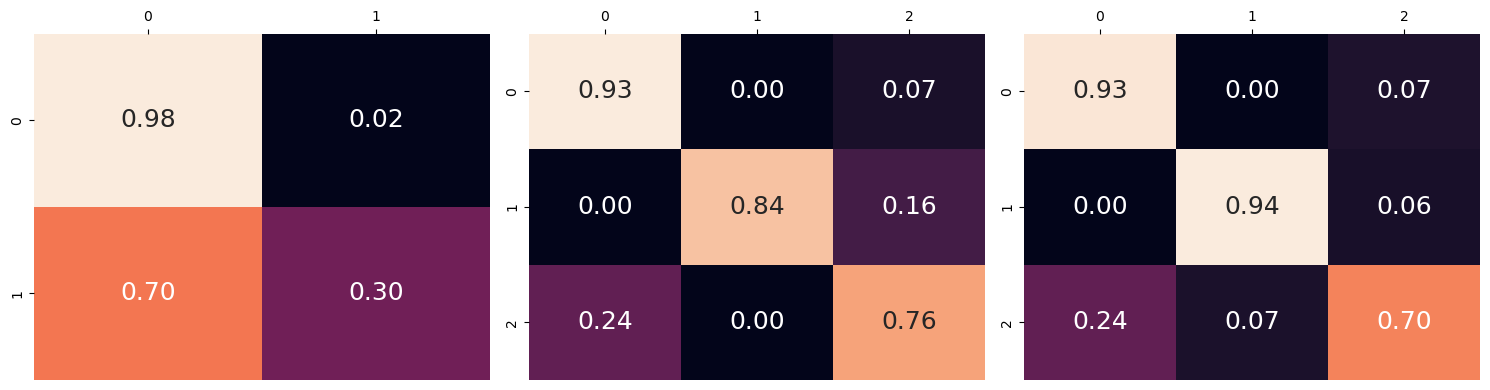

In [82]:
fig, ax = get_axes(L, max_col=4, fig_frame=(5,4), res=100)
for i,sys in enumerate(RATES):
    PLTmatrixrates(ax[i], RATES[sys])

fig.tight_layout() 
if SAVE_PLOT:
    fig.savefig('macro_clusters_pamm_matrix.png')

In [83]:
np.bincount(macro_cluster_output['400mol'])

array([48128, 16805, 15067])

In [84]:
["tab:orange", "tab:blue", "tab:green", "tab:red"]

['tab:orange', 'tab:blue', 'tab:green', 'tab:red']